# Reference
https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/02-Lets-get-you-a-robot-8f86172b-b597-4ceb-9bad-92d11ac7a6cc/notebook/simulation-1ba6290623e34dbbb9d822a2180187c1?

In [3]:
import numpy as np
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    GenerateHtml,
    InverseDynamicsController,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    LeafSystem,
    MathematicalProgram
)

# from manipulation import running_as_notebook

In [4]:
class StupidMPC(LeafSystem):
    def __init__(self, system, context, Q, R, period, horizon):
        LeafSystem.__init__(self)
        self._opti = MathematicalProgram()
        

from pydrake.systems.controllers import MakeFiniteHorizonLinearQuadraticRegulator

In [5]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [6]:
def run_simulation():
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
        "package://drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # pid controller
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(plant, kp, ki, kd, False)
    )
    iiwa_controller.set_name("iiwa_controller")

    # Connect ports
    builder.Connect(
        plant.get_state_output_port(iiwa_model),
        iiwa_controller.get_input_port_estimated_state()
    )
    builder.Connect(
        iiwa_controller.get_output_port_control(),
        plant.get_actuation_input_port()
    )
    diagram = builder.Build()
    diagram.set_name("iiwa plant + controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 2])
    x0 = np.hstack((q0, 2 * q0))
    plant.SetPositions(plant_context, q0)
    iiwa_controller.GetInputPort("desired_state").FixValue(
        iiwa_controller.GetMyMutableContextFromRoot(context), x0
    )
    print(context)
    # plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
    # plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))

    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)

    meshcat.StartRecording()
    simulator.AdvanceTo(10.0)
    meshcat.StopRecording()
    meshcat.PublishRecording()

    display(
    SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())
)


::iiwa plant + controller Context (of a Diagram)
-------------------------------------------------
7 total continuous states
14 total discrete states in 1 groups
291 total numeric parameters in 39 groups
10 total abstract parameters

::iiwa plant + controller::plant Context
-----------------------------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     2     0     0     0     0     0     0     0

Parameters:
  38 numeric parameter groups with
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       100
     1 parameters
       4.54e-05
     1 parameters
       160
     1 parameters
       4.54e-05
     1 parameters
       160
     10 parameters
       nan nan na

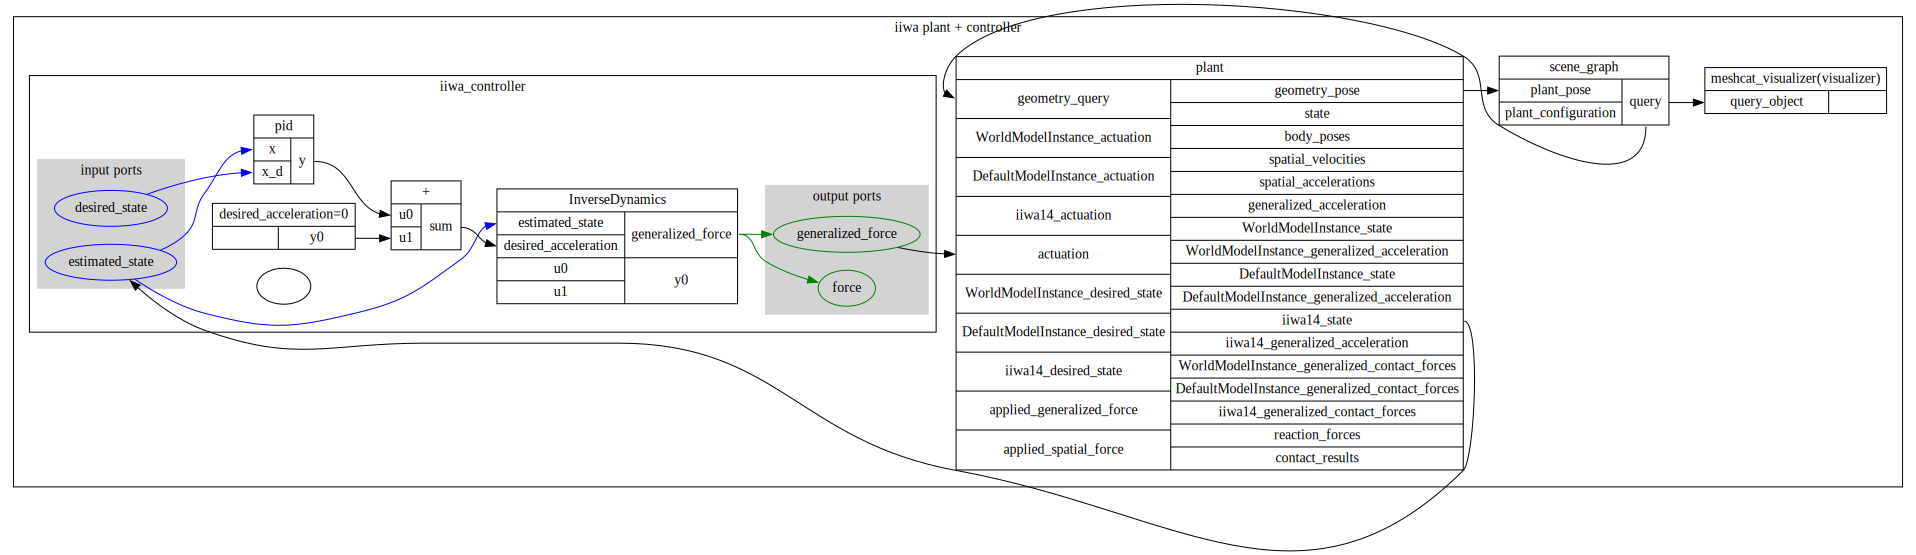

In [7]:
run_simulation()